In [1]:
'''
Husayn El Sharif
Rainfed Corn Yield Prediction (Southern Georgia Region) using Bi-Weekly Weather Data
'''

'\nHusayn El Sharif\nRainfed Corn Yield Prediction (Southern Georgia Region) using Bi-Weekly Weather Data\n'

In [2]:
# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import joblib

from sklearn.metrics import mean_squared_error # Import mean_squared_error from sklearn.metrics
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error


2025-01-06 17:02:01.386931: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 17:02:01.397189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736200921.409091  159948 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736200921.412564  159948 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 17:02:01.425456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Import Crop Model Data

crop_model_data_path = '01 Crop Model Results Agg Spreadsheets/corn_rainfed.xlsx'

imported_df_dictionary = pd.read_excel(crop_model_data_path, sheet_name = None)
sheet_names = list(imported_df_dictionary.keys()) # create a list of the sheet names

In [4]:
# Aggregate X (climate) and y data (yield)
# note: skip data from Years 1982 and 1985

X_list = [] # initialize
y_list = [] # initialize

for s in sheet_names:
    current_df = imported_df_dictionary[s]
    current_year = current_df['Year'].iloc[0]
    if current_year != 1982 and current_year != 1985:
        X_excerpt = current_df[['SRAD', 'TMAX', 'TMIN', 'TAVG', 'PRE']]
        y_excerpt = current_df[['YIELD']].iloc[0]
        X_list.append(X_excerpt)
        y_list.append(y_excerpt)

# convert to numpy arrays
X_data = np.array(X_list)
y_data = np.array(y_list)
        

In [5]:
# Samples, features, and targets
num_samples = X_data.shape[0]
num_features = X_data.shape[1]
num_targets = y_data.shape[1]

In [6]:
# Fit scalers
input_scaler = MinMaxScaler() # initialize
input_scaler = input_scaler.fit(pd.concat(X_list, axis=0))

output_scaler =  MinMaxScaler() # initialize
output_scaler = output_scaler.fit(pd.DataFrame(y_data))


In [7]:
# scale data
X_data_scaled_df = pd.DataFrame(input_scaler.transform(pd.concat(X_list, axis=0)), columns=['SRAD', 'TMAX', 'TMIN', 'TAVG', 'PRE'] )
y_data_scaled_df = pd.DataFrame(output_scaler.transform(pd.DataFrame(y_data)), columns=['YIELD'] )

In [8]:
# split scaled data into samples. Every 16 rows is a sample

In [9]:
X_data_scaled_list = []
y_data_scaled_list = []

rows_per_sample = 16
for r in range(0, len(X_data_scaled_df), rows_per_sample):
    X_excerpt = X_data_scaled_df.iloc[r:r+rows_per_sample].values
    X_data_scaled_list.append(X_excerpt)

for r in range(0, len(y_data_scaled_df)):
    y_excerpt = y_data_scaled_df.iloc[r].values
    y_data_scaled_list.append(y_excerpt)

In [10]:
# convert to numpy arrays for LSTM
X_data_scaled_array = np.array(X_data_scaled_list)
y_data_scaled_array = np.array(y_data_scaled_list)

In [11]:
# Split X_data_scaled_array and y_data_scaled_array into Train (80%, 280 samples), Validation (10%, 35 samples), and Test (10%, 35 smaples) data
X_data_scaled_array_shuffled, y_data_scaled_array_shuffled = shuffle(X_data_scaled_array, y_data_scaled_array, random_state=12232)


In [12]:
# Split into Train, Val, Test
X_train = X_data_scaled_array_shuffled[0:280]
X_val = X_data_scaled_array_shuffled[280:280+35]
X_test = X_data_scaled_array_shuffled[280+35:280+35+35]

y_train = y_data_scaled_array_shuffled[0:280]
y_val = y_data_scaled_array_shuffled[280:280+35]
y_test = y_data_scaled_array_shuffled[280+35:280+35+35]

In [13]:
X_train.shape

(280, 16, 5)

In [14]:
# Build Model

LSTM_Model = Sequential() # initialize

# input layer
LSTM_Model.add(
    Input(
        shape=(X_train.shape[1], X_train.shape[2]) # shape = (number of time steps within a sample, number of features)
    ))

# Hidden Layer 1, with dropout regulariation layer, return sequences
LSTM_Model.add( LSTM(units=50, return_sequences = True) )
LSTM_Model.add(Dropout(0.2))

# Hidden Layer 2, with dropout regulariation layer, return sequences
LSTM_Model.add( LSTM(units=50, return_sequences = True) )
LSTM_Model.add(Dropout(0.2))

# Hidden Layer 3, with dropout regulariation layer, do not return sequences
LSTM_Model.add( LSTM(units=50, return_sequences = False) )
LSTM_Model.add(Dropout(0.2))

# Final Layer, Dense/Output Layer
LSTM_Model.add( Dense(units=1) )

# Compile model
LSTM_Model.compile( optimizer = "adam", loss = "mean_squared_error")

I0000 00:00:1736200924.333644  159948 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2053 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [15]:
# Train Model

model_location = "models/"
model_name = "lstm_rainfed_corn_yield.model.keras"
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name, 
    monitor="val_loss", 
    save_best_only=True, 
    mode="min", 
    verbose=0)

history = LSTM_Model.fit(
    x = X_train, 
    y = y_train, 
    epochs=500, 
    validation_data=(X_val, y_val),
    batch_size = 30, 
    callbacks = [best_model_checkpoint_callback])

Epoch 1/500


I0000 00:00:1736200926.836782  160050 cuda_dnn.cc:529] Loaded cuDNN version 90300


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.1628 - val_loss: 0.0647
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0751 - val_loss: 0.0623
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0718 - val_loss: 0.0607
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0646 - val_loss: 0.0596
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0593 - val_loss: 0.0584
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0604 - val_loss: 0.0552
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0555 - val_loss: 0.0498
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0435 - val_loss: 0.0440
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0372 - val_loss: 0.0404
Epoch 10/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0376 - val_loss: 0.0395
Epoch 11/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0443 - val_loss: 0.0415
Epoch 12/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

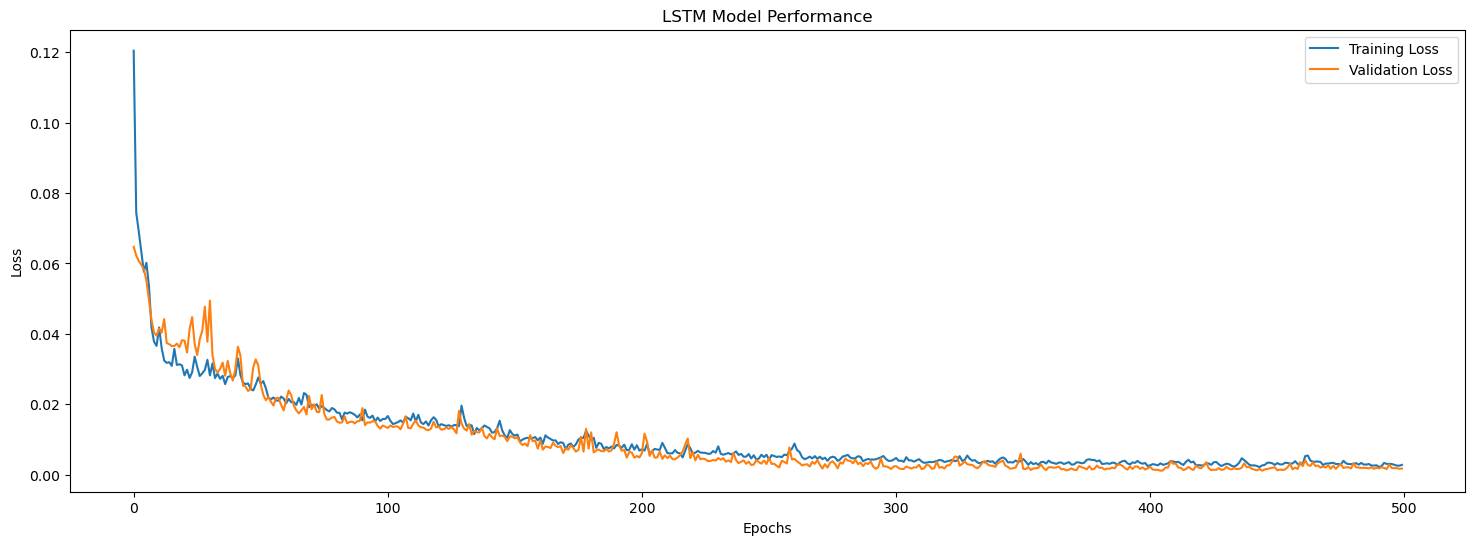

In [16]:
# Visualize Model Performance During Training

plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
# Load Best Model
best_model = load_model(model_location + model_name)

In [18]:
# Model Prediction
# Predict crop yield for all data splits (scaled results)
y_train_predict = best_model.predict(X_train)
y_val_predict = best_model.predict(X_val)
y_test_predict = best_model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [19]:
# reverse scaling
y_train_inv = output_scaler.inverse_transform(y_train)
y_val_inv = output_scaler.inverse_transform(y_val)
y_test_inv = output_scaler.inverse_transform(y_test)

y_train_predict_inv = output_scaler.inverse_transform(y_train_predict)
y_val_predict_inv = output_scaler.inverse_transform(y_val_predict)
y_test_predict_inv = output_scaler.inverse_transform(y_test_predict)

Text(0, 0.5, 'Prediction')

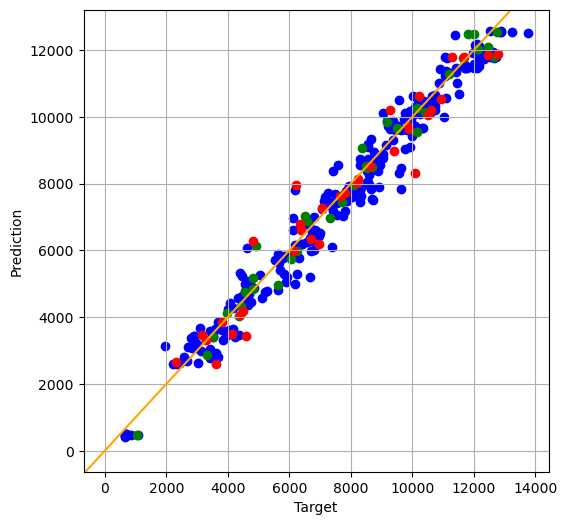

In [20]:
# plot results as scatter
plt.figure(figsize=(6,6))

# train (blue)
plt.scatter(x=y_train_inv, y=y_train_predict_inv, c='blue')

# val (green)
plt.scatter(x=y_val_inv, y=y_val_predict_inv, c='green')

# test (red)
plt.scatter(x=y_test_inv, y=y_test_predict_inv, c='red')

plt.grid(visible=True, which='major', axis='both')
plt.axline([0, 0], [1, 1], c='orange')
plt.xlabel('Target')
plt.ylabel('Prediction')


Text(0, 0.5, 'Prediction')

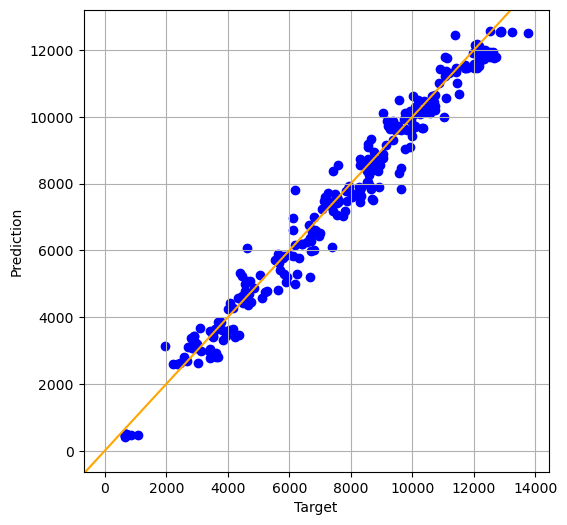

In [21]:
# Training Scatter Plot

# plot results as scatter
plt.figure(figsize=(6,6))

# train (blue)
plt.scatter(x=y_train_inv, y=y_train_predict_inv, c='blue')

plt.grid(visible=True, which='major', axis='both')
plt.axline([0, 0], [1, 1], c='orange')

plt.xlabel('Target')
plt.ylabel('Prediction')

Text(0, 0.5, 'Prediction')

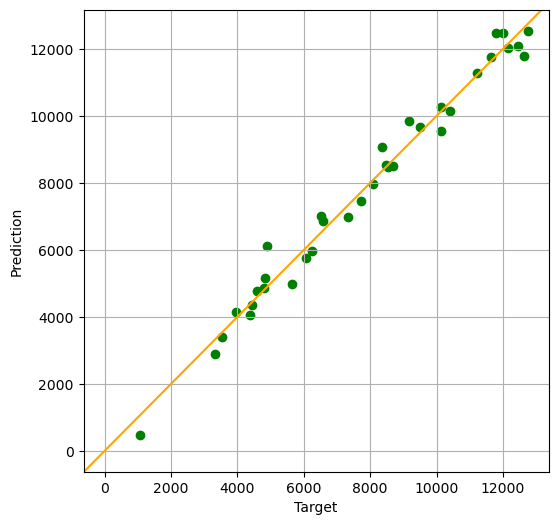

In [22]:
# Validation Scatter Plot
# plot results as scatter
plt.figure(figsize=(6,6))


# val (green)
plt.scatter(x=y_val_inv, y=y_val_predict_inv, c='green')


plt.grid(visible=True, which='major', axis='both')
plt.axline([0, 0], [1, 1], c='orange')

plt.xlabel('Target')
plt.ylabel('Prediction')

Text(0, 0.5, 'Prediction')

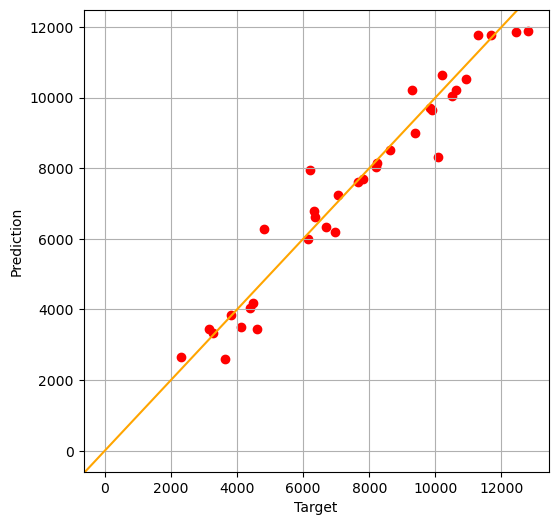

In [23]:
# Testing Scatter Plot

# plot results as scatter
plt.figure(figsize=(6,6))

# test (red)
plt.scatter(x=y_test_inv, y=y_test_predict_inv, c='red')

plt.grid(visible=True, which='major', axis='both')
plt.axline([0, 0], [1, 1], c='orange')

plt.xlabel('Target')
plt.ylabel('Prediction')

In [24]:
# Performance Metrics: Train

rmse = root_mean_squared_error(y_train_inv, y_train_predict_inv)
r2 = r2_score(y_train_inv, y_train_predict_inv)
mae = mean_absolute_error(y_train_inv, y_train_predict_inv)

print('RMSE: {:.2f} kg/ha '.format(rmse))
print('MAE: {:.2f} kg/ha'.format(mae))
print('R2: {:.2f}'.format(r2))

RMSE: 512.85 kg/ha 
MAE: 399.41 kg/ha
R2: 0.97


In [25]:
# Performance Metrics: Validation

rmse = root_mean_squared_error(y_val_inv, y_val_predict_inv)
r2 = r2_score(y_val_inv, y_val_predict_inv)
mae = mean_absolute_error(y_val_inv, y_val_predict_inv)

print('RMSE: {:.2f} kg/ha '.format(rmse))
print('MAE: {:.2f} kg/ha'.format(mae))
print('R2: {:.2f}'.format(r2))

RMSE: 436.59 kg/ha 
MAE: 347.21 kg/ha
R2: 0.98


In [26]:
# Performance Metrics: Testing

rmse = root_mean_squared_error(y_test_inv, y_test_predict_inv)
r2 = r2_score(y_test_inv, y_test_predict_inv)
mae = mean_absolute_error(y_test_inv, y_test_predict_inv)

print('RMSE: {:.2f} kg/ha '.format(rmse))
print('MAE: {:.2f} kg/ha'.format(mae))
print('R2: {:.2f}'.format(r2))

RMSE: 672.29 kg/ha 
MAE: 495.22 kg/ha
R2: 0.95
